# Importing Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.4 MB/s eta 0:00:00


In [ ]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Import Dataset

In [ ]:
xls = pd.ExcelFile('/content/drive/MyDrive/DataFinalNew.xlsx')
read_file = pd.read_excel (xls,"Lembar1")
#export file menjadi csv
read_file.to_csv (r'/content/DataFinal.csv', index = None, header=True)

In [ ]:
data = pd.read_csv("/content/DataFinal.csv")
data = data.dropna()
data['Label'] = data['Label'].astype(int)
data.isnull().any()

Tweet    False
Label    False
dtype: bool

In [ ]:
print(data.count())

data['Label'].value_counts()

Tweet    30179
Label    30179
dtype: int64


1    15288
0    14891
Name: Label, dtype: int64

In [ ]:
texts = data['Tweet'].tolist()

sentence_lengths = [len(text.split()) for text in texts]

# Calculate maximum sentence length
max_length = max(sentence_lengths)

# Calculate average sentence length
avg_length = sum(sentence_lengths) / len(sentence_lengths)

print("Maximum Sentence Length:", max_length)
print("Average Sentence Length:", avg_length)

Maximum Sentence Length: 63
Average Sentence Length: 13.555319924450776


In [ ]:
for i in range(0,len(data)):
    if data['Label'].iloc[i] == 2:
        data['Label'].iloc[i] = 0

In [ ]:
data.head()

,Tweet,Label
0,kalo langsung dipakai tidak biasanya ya,0
1,memek aku tidak merah muda,0
2,cocok keluarga alister semua bibit perusak hub...,1
3,kak jangan pernah percaya lonte digital,1
4,memang lonte sakit kali kepalaku mau kelahi sa...,1


# WordCloud

In [ ]:
%cd /content/drive/MyDrive/Training NLP

/content/drive/MyDrive/Training NLP


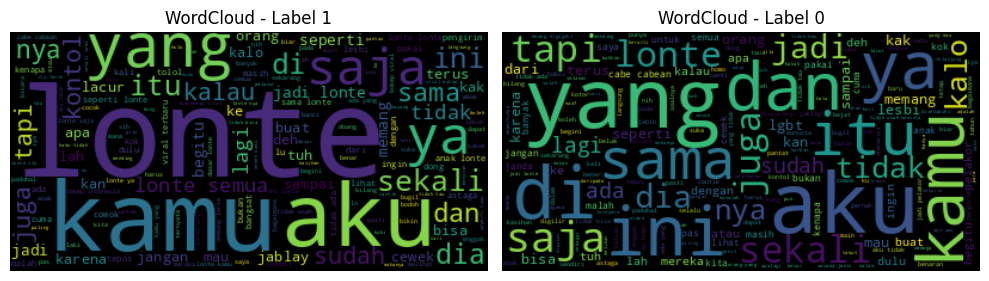

In [ ]:
data_label_1 = data[data['Label'] == 1]
data_label_0 = data[data['Label'] == 0]

text_label_1 = ' '.join(data_label_1['Tweet'])
text_label_0 = ' '.join(data_label_0['Tweet'])

wordcloud_label_1 = WordCloud().generate(text_label_1)
wordcloud_label_0 = WordCloud().generate(text_label_0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_label_1, interpolation='bilinear')
plt.title('WordCloud - Label 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_label_0, interpolation='bilinear')
plt.title('WordCloud - Label 0')
plt.axis('off')

plt.tight_layout()
plt.savefig('WordCloud.png')
plt.show()


# Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

train_dataset, val = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['Label'])

val_dataset, test_dataset = train_test_split(val, test_size=0.5, random_state=42, shuffle=True, stratify=val['Label'])

print('Train Dataset:')
print(len(train_dataset))
print(train_dataset['Label'].value_counts())
print('\n')

print('Validation Dataset:')
print(len(val_dataset))
print(val_dataset['Label'].value_counts())
print('\n')

print('Test Dataset:')
print(len(test_dataset))
print(test_dataset['Label'].value_counts())

Train Dataset:
24143
1    12230
0    11913
Name: Label, dtype: int64


Validation Dataset:
3018
1    1529
0    1489
Name: Label, dtype: int64


Test Dataset:
3018
1    1529
0    1489
Name: Label, dtype: int64


In [ ]:
train_dataset.head()

,Tweet,Label
12616,mana ada aku mesum itu aku cuma jawab pertanya...,0
2829,aku mau sekali lonte ini tidak harus lepas jil...,1
18659,lu tidak lihat kasihan ya lesbi cowok tidak di...,1
29388,pesta jijik hina kesucian bulan sama kaum nabi...,0
3986,lonte cowo,1


In [ ]:
val_dataset.head()

,Tweet,Label
28659,bejat pemuda tahun rudapaksa remaja wanita di ...,0
23243,bokep jepang bokep indonesia terbalas lonte bo...,0
19571,bukan pintar koleksi bokep lgbt kan,0
24116,lo yang aku namain anak lonte karena bodoh,1
2479,mau bertanya kak nonton homo haram enggak,0


In [ ]:
test_dataset.head()

,Tweet,Label
29732,tapi au homo,0
14446,bismillah tahun ini jadi tahun terakhir bulan ...,0
4872,cantik gall nu gemas dia janda,0
27205,jalan jalan jual lacur,1
3521,enggak bisa apa apaan sudah end lanjut tidak k...,1


In [ ]:
train_dataset.reset_index(drop=True, inplace=True)

val_dataset.reset_index(drop=True, inplace=True)

test_dataset.reset_index(drop=True, inplace=True)

# Preprocessing

In [ ]:
%cd /content/drive/MyDrive/Training NLP/INDOXLNET

/content/drive/.shortcut-targets-by-id/1oT2aMyY1BEL098bKUCgF6iLI5qE55GiH/Training NLP/INDOXLNET


In [ ]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/indoxlnet-deploy')

In [ ]:
max_length= 63
batch_size = 16

train_encodings = tokenizer(train_dataset['Tweet'].tolist(), truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(val_dataset['Tweet'].tolist(), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_dataset['Tweet'].tolist(), truncation=True, padding=True, max_length=max_length)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_dataset['Label'])
val_labels = tf.convert_to_tensor(val_dataset['Label'])
test_labels = tf.convert_to_tensor(test_dataset['Label'])

# Create TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_data = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))
test_data = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

# Prepare the datasets for training and evaluation
train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)
test_data = test_data.batch(batch_size)

# Creating Model

In [ ]:
# Initialize model for sequence classification
pt_model = TFAutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/indoxlnet-deploy')

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
All model checkpoint layers were used when initializing TFXLNetForSequenceClassification.

Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/indoxlnet-deploy and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#create layer
input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
embeddings = pt_model(input_ids, attention_mask=attention_mask)[0]
outputs = Dense(1, activation='sigmoid')(embeddings)

# Membuat model dengan input dan output
model = Model(inputs=[input_ids, attention_mask], outputs=outputs)

# Define optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
loss = BinaryCrossentropy()
metric = BinaryAccuracy('accuracy')

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 63)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 63)]         0           []                               
                                                                                                  
 tfxl_net_for_sequence_classifi  TFXLNetForSequenceC  117310466  ['input_ids[0][0]',              
 cation (TFXLNetForSequenceClas  lassificationOutput              'attention_mask[0][0]']         
 sification)                    (loss=None, logits=                                               
                                (None, 2),                                                    

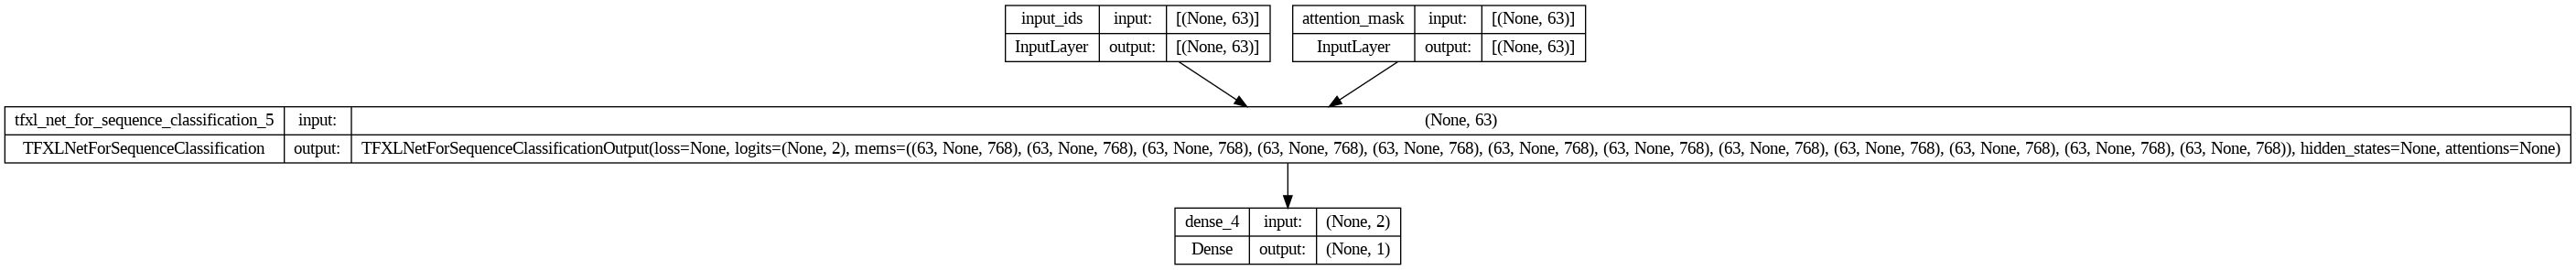

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', expand_nested=True, show_shapes=True)

In [ ]:
start_time = time.time()

history = model.fit(train_data, epochs=5, validation_data=val_data, callbacks=[early_stopping])

end_time = time.time()
training_time = end_time - start_time

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1509/1509 [==============================] - 489s 294ms/step - loss: 0.6384 - accuracy: 0.6323 - val_loss: 0.5348 - val_accuracy: 0.7628
Epoch 2/5
1509/1509 [==============================] - 417s 277ms/step - loss: 0.5081 - accuracy: 0.7742 - val_loss: 0.4956 - val_accuracy: 0.7850
Epoch 3/5
1509/1509 [==============================] - 422s 279ms/step - loss: 0.4785 - accuracy: 0.7911 - val_loss: 0.4722 - val_accuracy: 0.7949
Epoch 4/5
1509/1509 [==============================] - 418s 277ms/step - loss: 0.4586 - accuracy: 0.8040 - val_loss: 0.4477 - val_accuracy: 0.8075
Epoch 5/5
1509/1509 [==============================] - 417s 276ms/step - loss: 0.4446 - accuracy: 0.8109 - val_loss: 0.4334 - val_accuracy: 0.8125


In [ ]:
# Simpan model fine-tuned
model.save('tf_model.h5')

# Dapatkan konfigurasi model BERT
model_config = model.get_config()

# Simpan konfigurasi sebagai JSON
with open('config.json', 'w') as f:
    json.dump(model_config, f)

# Simpan tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/Training NLP/BERT')

('/content/drive/MyDrive/Training NLP/BERT/tokenizer_config.json',
 '/content/drive/MyDrive/Training NLP/BERT/special_tokens_map.json',
 '/content/drive/MyDrive/Training NLP/BERT/vocab.txt',
 '/content/drive/MyDrive/Training NLP/BERT/added_tokens.json',
 '/content/drive/MyDrive/Training NLP/BERT/tokenizer.json')

In [ ]:
results_file = 'training_results 9 32 5.txt'
with open(results_file, 'w') as f:
    f.write(f"Training Time: {training_time:.2f} seconds\n")
    f.write(f"Training Accuracy: {history.history['accuracy']}\n")
    f.write(f"Training Loss: {history.history['loss']}\n")
    f.write(f"Validation Accuracy: {history.history['val_accuracy']}\n")
    f.write(f"Validation Loss: {history.history['val_loss']}\n")

# Testing

In [ ]:
test_predictions = model.predict(test_data)


 43/189 [=====>........................] - ETA: 13s

In [ ]:
test_predictions = test_predictions.flatten()
test_predictions = np.where(test_predictions > 0.5, 1, 0)
print(test_predictions)

[0 0 0 ... 0 0 0]


In [ ]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Text': test_dataset['Tweet'],  # Replace with the appropriate column from your test data
    'Ground Truth Label': test_dataset['Label'],
    'Predicted Label': test_predictions
})

# Save the results to a CSV file
results_df.to_csv('predictions.csv', index=False)

In [ ]:
test_labels = test_labels

# Calculate F1-score
f1 = f1_score(test_labels, test_predictions)
print("F1-score:", f1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(test_labels, test_predictions)
print("Precision:", precision)

# Calculate recall
recall = recall_score(test_labels, test_predictions)
print("Recall:", recall)

print("\n")
print(classification_report(test_labels, test_predictions))

print("confusion matrix:")
cm = confusion_matrix(test_labels, test_predictions)
print(cm)

F1-score: 0.8122270742358079
Accuracy: 0.8005301524188204
Precision: 0.7759237187127532
Recall: 0.8520942408376964


              precision    recall  f1-score   support

           0       0.83      0.75      0.79       745
           1       0.78      0.85      0.81       764

    accuracy                           0.80      1509
   macro avg       0.80      0.80      0.80      1509
weighted avg       0.80      0.80      0.80      1509

confusion matrix:
[[557 188]
 [113 651]]


In [ ]:
with open('evaluation_results 9 32 5.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy}\n')
    f.write(f'Precision: {precision}\n')
    f.write(f'Recall: {recall}\n')
    f.write(f'F1-Score: {f1}\n')
    f.write(f'Confusion Matrix:\n{cm}\n')

In [ ]:
# Perform inference on new texts
new_texts = "kamu cantik"
encoded_inputs = tokenizer(new_texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')

input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

# Make predictions
outputs = model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]
predicted_label = np.where(outputs > 0.5, 1, 0)[0]

label_mapping = {0: "bukan pelecehan", 1: "pelecehan seksual"}
predicted_label = label_mapping[predicted_label]

print("Predictions:")
print("Text:", new_texts)
print("Predicted Label:", predicted_label)

Predictions:
Text: kamu cantik
Predicted Label: bukan pelecehan


### Visualizing Performance

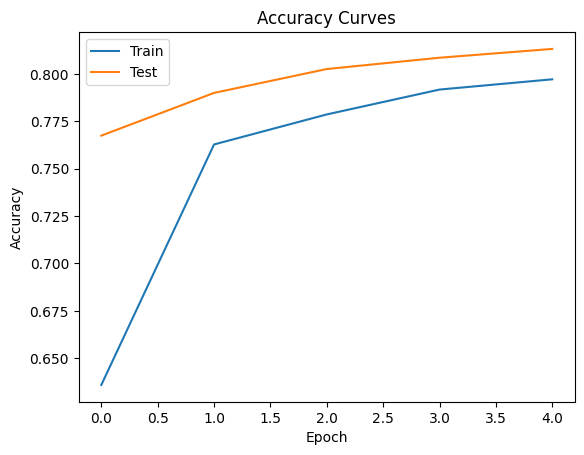

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('plot acc 9 32 5.png')
plt.show()

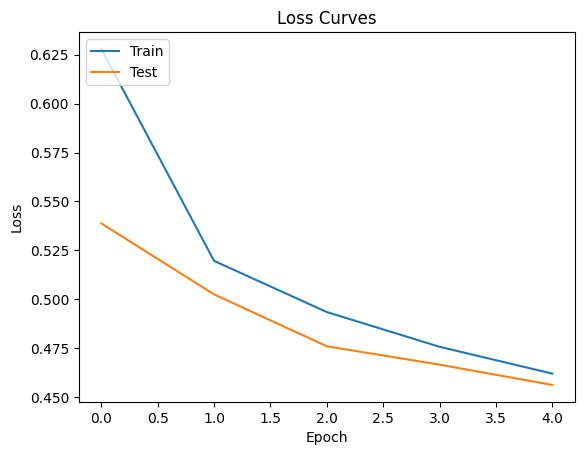

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('plot loss 9 32 5.png')
plt.show()

# Deploy HuggingFace


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Your token has been saved in your

In [ ]:
cd /content/drive/MyDrive/Training NLP/INDOXLNET/IndoXLNet

/content/drive/.shortcut-targets-by-id/1oT2aMyY1BEL098bKUCgF6iLI5qE55GiH/Training NLP/INDOXLNET/IndoXLNet


In [ ]:
!huggingface-cli repo create indoxlnet-indonesia-sexual

git version 2.25.1
git-lfs/2.9.2 (GitHub; linux amd64; go 1.13.5)

You are about to create itsam26/indoxlnet-indonesia-sexual
Proceed? [Y/n] y

Your repo now lives at:
  https://huggingface.co/itsam26/indoxlnet-indonesia-sexual

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/itsam26/indoxlnet-indonesia-sexual



In [ ]:
!git config --global user.email "afrizal.bbm123@gmail.com"
!git config --global user.name "Afrizal2609"

In [ ]:
!git clone https://huggingface.co/itsam26/indoxlnet-indonesia-sexual

Cloning into 'indoxlnet-indonesia-sexual'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 422 bytes | 6.00 KiB/s, done.


In [ ]:
cd /content/drive/MyDrive/Training NLP/INDOXLNET/IndoXLNet/indoxlnet-indonesia-sexual

/content/drive/.shortcut-targets-by-id/1oT2aMyY1BEL098bKUCgF6iLI5qE55GiH/Training NLP/INDOXLNET/IndoXLNet/indoxlnet-indonesia-sexual


In [ ]:
!echo "indoxlnet model for sexual harassment classification in Bahasa Indonesia" >> Readme.md

In [ ]:
!git add .

In [ ]:
!chmod +x .git/hooks/post-commit

In [ ]:
!git commit -m "upload model"

On branch main
Your branch is ahead of 'origin/main' by 2 commits.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [ ]:
!chmod +x .git/hooks/pre-push

In [ ]:
!git push origin main

Uploading LFS objects: 100% (2/2), 1.4 GB | 109 MB/s, done.
Enumerating objects: 12, done.
Counting objects: 100% (12/12), done.
Delta compression using up to 2 threads
Compressing objects: 100% (11/11), done.
Writing objects: 100% (11/11), 586.10 KiB | 6.23 MiB/s, done.
Total 11 (delta 1), reused 0 (delta 0)
To https://huggingface.co/itsam26/indoxlnet-indonesia-sexual
   7855081..56dc069  main -> main
